In [48]:
import pandas as pd 
import numpy as np

# === Load motion capture data ===
file_path = r"D:\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\2nd_Braille Display\Final Participant Data\AB Participants\03262024_ABParticipant 5\ABParticipant5_NB\Trajectory\NB_1.5mm0.75mm_SL1M2.csv"
df = pd.read_csv(file_path, skiprows=3, header=0)
df = df.apply(pd.to_numeric, errors='coerce').reset_index(drop=True)
extracted_df = df.iloc[3:, 1:]  # Remove extra headers

# === Extract RigidBody016 X/Y data ===
rigidbody016_cols = [col for col in extracted_df.columns if 'RigidBody 016' in col or 'RigidBody016' in col]
df_rigidbody016 = extracted_df[rigidbody016_cols].copy().reset_index(drop=True)
xyz_cols = [col for col in df_rigidbody016.columns if 'RigidBody 016.4' in col or 'RigidBody 016.6' in col]

df_rigidbody016_xyz = df_rigidbody016[xyz_cols].rename(columns={
    'RigidBody 016.4': 'Head_X',
    'RigidBody 016.6': 'Head_Y'
})
extracted_headxy = df_rigidbody016_xyz[['Head_X', 'Head_Y']].dropna().reset_index(drop=True)
observations = extracted_headxy.values

# === Kalman Filter Setup ===
dt = 1.0 / 120.0  # 120 Hz
n_timesteps = len(observations)

# State: [x, y, vx, vy]
x = np.array([observations[0, 0], observations[0, 1], 0, 0], dtype=float)  # initial state

x_est = np.zeros((n_timesteps, 4))  # store full state [x, y, vx, vy]

P = np.eye(4)  # initial error covariance

F = np.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1,  0],
    [0, 0, 0,  1]
])  # constant velocity model
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])  # we observe only x and y

R = np.array([[1.85, 0],
              [0, 1.85]])  # measurement noise in mm^2

# Refined process noise for 120 Hz
q_pos = 5e-1
q_vel = 5e-1
Q = np.array([
    [q_pos, 0,     0,     0],
    [0,     q_pos, 0,     0],
    [0,     0,     q_vel, 0],
    [0,     0,     0,     q_vel]
])

# === Kalman Filter Loop ===
for t in range(n_timesteps):
    z = observations[t]  # position measurement [x, y]

    # Predict
    x_pred = F @ x
    P_pred = F @ P @ F.T + Q

    # Update
    y = z - H @ x_pred                   # innovation
    S = H @ P_pred @ H.T + R             # innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x = x_pred + K @ y                   # posterior state
    P = (np.eye(4) - K @ H) @ P_pred     # posterior covariance

    x_est[t] = x  # store full state

# Add smoothed position to DataFrame
extracted_headxy[['Kalman_X', 'Kalman_Y']] = x_est[:, :2]

# ✅ Preview filtered results
print(extracted_headxy.head())


     Head_X    Head_Y  Kalman_X  Kalman_Y
0 -1.723013  0.058958 -1.723013  0.058958
1 -1.723020  0.058958 -1.723016  0.058958
2 -1.722362  0.058879 -1.722749  0.058926
3 -1.722348  0.058846 -1.722587  0.058894
4 -1.721954  0.059403 -1.722332  0.059099


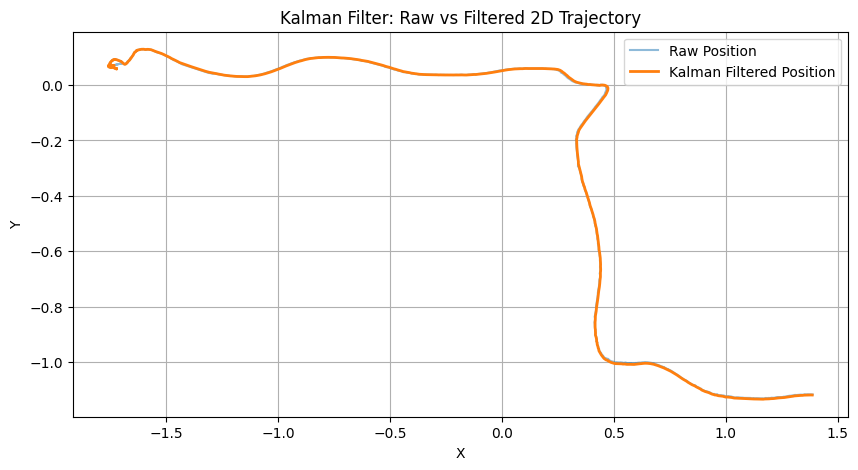

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(extracted_headxy['Head_X'], extracted_headxy['Head_Y'], label='Raw Position', alpha=0.5)
plt.plot(extracted_headxy['Kalman_X'], extracted_headxy['Kalman_Y'], label='Kalman Filtered Position', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kalman Filter: Raw vs Filtered 2D Trajectory')
plt.legend()
plt.grid(True)
plt.show()


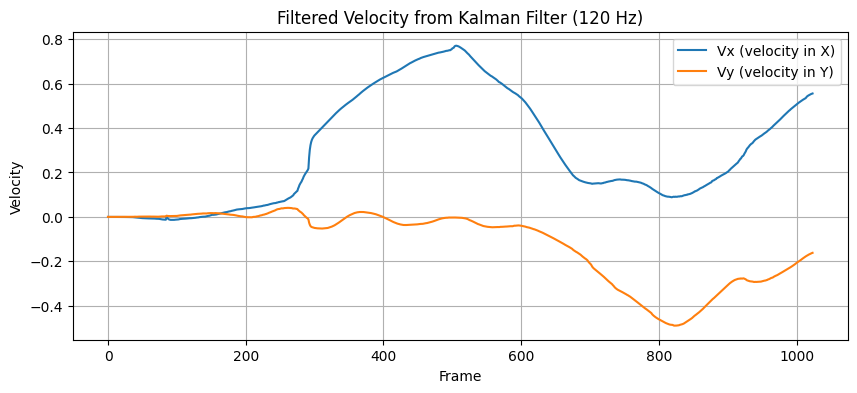

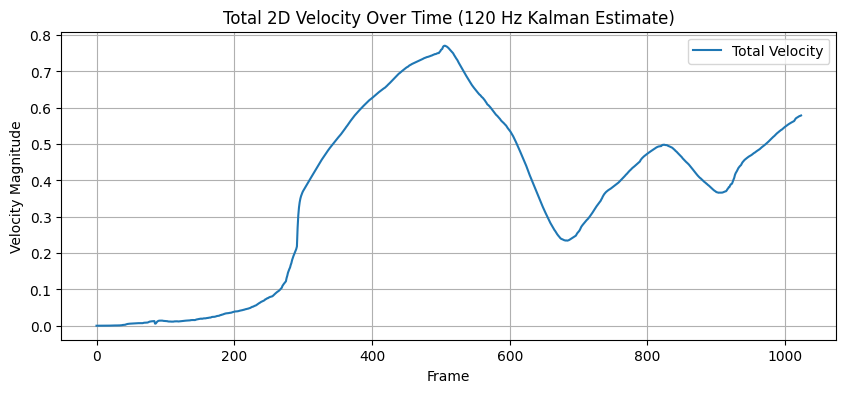

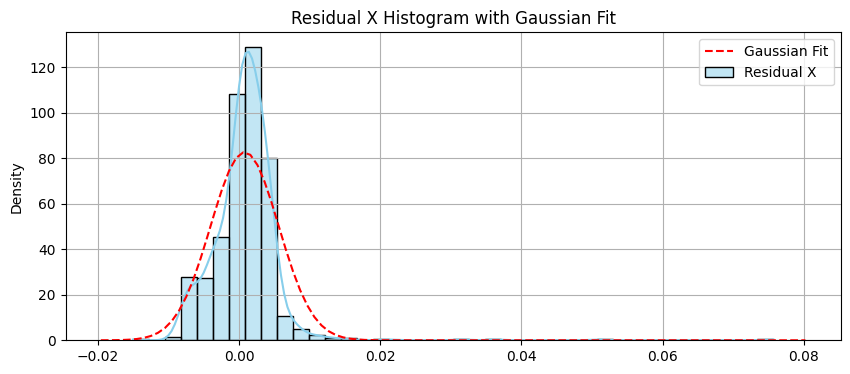

Shapiro-Wilk test p-value (X): 0.0000


In [50]:
import matplotlib.pyplot as plt
filtered_velocity = x_est[:, 2:]  # shape = (n_timesteps, 2)
total_velocity = np.linalg.norm(filtered_velocity, axis=1)  # shape: (n_timesteps,)

plt.figure(figsize=(10,4))
plt.plot(filtered_velocity[:, 0], label='Vx (velocity in X)')
plt.plot(filtered_velocity[:, 1], label='Vy (velocity in Y)')
plt.xlabel("Frame")
plt.ylabel("Velocity")
plt.title("Filtered Velocity from Kalman Filter (120 Hz)")
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(10,4))
plt.plot(total_velocity, label='Total Velocity')
plt.xlabel("Frame")
plt.ylabel("Velocity Magnitude")
plt.title("Total 2D Velocity Over Time (120 Hz Kalman Estimate)")
plt.grid()
plt.legend()
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

residuals = observations - x_est[:, :2]
residual_x = residuals[:, 0]
residual_y = residuals[:, 1]

# Plot residuals in X
plt.figure(figsize=(10, 4))
sns.histplot(residual_x, kde=True, stat="density", bins=40, color='skyblue', label='Residual X')
mu, std = residual_x.mean(), residual_x.std()
xmin, xmax = plt.xlim()
x_vals = np.linspace(xmin, xmax, 100)
plt.plot(x_vals, norm.pdf(x_vals, mu, std), 'r--', label='Gaussian Fit')
plt.title("Residual X Histogram with Gaussian Fit")
plt.legend()
plt.grid()
plt.show()

from scipy.stats import shapiro
stat, p = shapiro(residual_x)
print(f"Shapiro-Wilk test p-value (X): {p:.4f}")



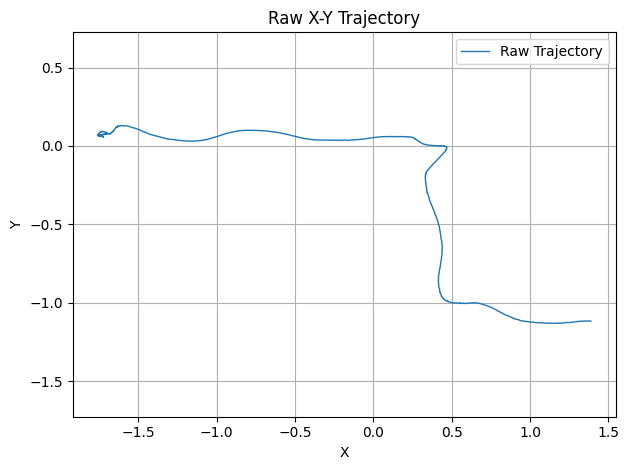

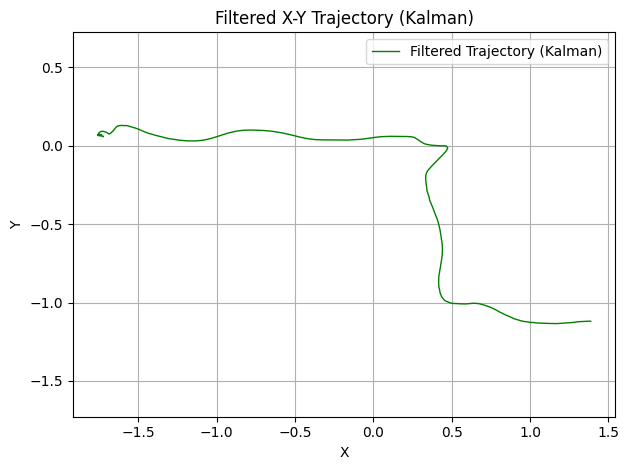

In [51]:
plt.figure()
plt.plot(extracted_headxy['Head_X'], extracted_headxy['Head_Y'], label='Raw Trajectory', linewidth=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Raw X-Y Trajectory')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# Plot filtered trajectory (Kalman filtered X vs Y)
plt.figure()
plt.plot(extracted_headxy['Kalman_X'], extracted_headxy['Kalman_Y'], label='Filtered Trajectory (Kalman)', linewidth=1, color='green')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Filtered X-Y Trajectory (Kalman)')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()
